In [137]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob
from keras.preprocessing import image
from sklearn.cluster import KMeans
from skimage.feature import hog
from skimage import exposure
from skimage.measure import label

**9.1.1 View Hog Feature of Image**

In [138]:
# Load main images in dataset
all_files = glob.glob("Animals/*/*.*")
print(all_files[:4])

['Animals/Dogs/dog10.jpg', 'Animals/Dogs/dog5.jpg', 'Animals/Dogs/dog11.png', 'Animals/Dogs/dog4.jpg']


In [139]:

image = []
for i in all_files[:4]:
  lst = []
  img = cv2.imread(i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Create Image Feature
    # Bluring image to reduce noise
  blur = cv2.GaussianBlur(img,(15,15),0) #Gaussian Filtering

  # Calculate HoG of image
  fd, hog_image = hog(blur, orientations=9,pixels_per_cell=(8,8),cells_per_block=(2,2),visualize=True,multichannel=True)

  lst.append(img)
  lst.append(blur)
  lst.append(fd)
  lst.append(hog_image)
  image.append(lst)


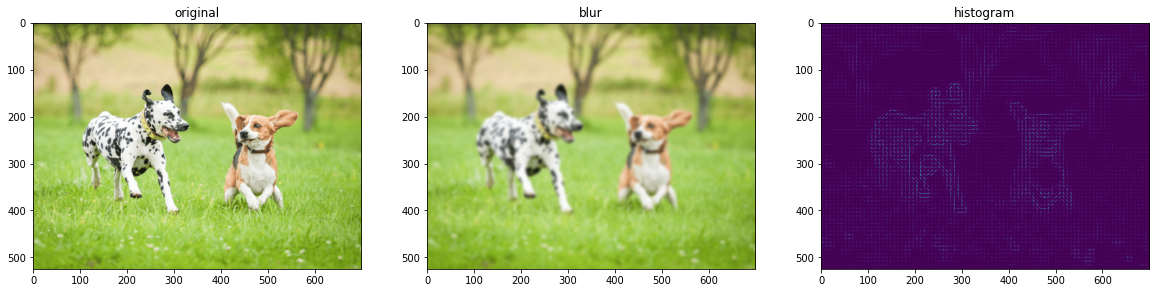

In [140]:
fig = plt.figure(figsize=(20,20))
ax = plt.subplot(1,3,1)
ax = plt.imshow(image[2][0])
ax = plt.title('original')


ax = plt.subplot(1,3,2)
ax = plt.imshow(image[2][1])
ax = plt.title('blur')

ax = plt.subplot(1,3,3)
ax = plt.imshow(image[2][3])
ax = plt.title('histogram')

**9.1.2 Prepare Hog Feature of Subimages**

In [141]:
# Define block size for subimage
# height, width = [40, 60], [20, 30, 40]
Block_size = (40,20)

# Define stride (ระยะขยับ pixel เพื่อทำ sliding window เพื่อคำนวณ HoG)
tx, ty = 5, 5
Stride = (tx, ty)

selected_img = cv2.imread(all_files[2])
selected_img = cv2.cvtColor(selected_img, cv2.COLOR_BGR2RGB)

h, w, c = selected_img.shape
print(selected_img.shape)

(525, 700, 3)


In [142]:
# Define Sliding window position of row, column (Top left position)
posRow = np.arange(0, selected_img.shape[0] - Block_size[0]+1, Stride[0])
posCol = np.arange(0, selected_img.shape[1] - Block_size[1]+1, Stride[1])
print(posRow,posCol)


[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355
 360 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445
 450 455 460 465 470 475 480 485] [  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355
 360 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445
 450 455 460 465 470 475 480 485 490 495 500 505 510 515 520 525 530 535
 540 545 550 555 560 565 570 575 580 585 590 595 600 605 610 615 620 625
 630 635 640 645 650 655 660 665 670 675 680]


In [143]:
# Create subimage feature
    # Calculate HoG of each subimage in Sliding window
hogfeatures = []

for i in range(len(posRow)):
    for j in range(len(posCol)):
        startH = posRow[i]
        endH = posRow[i] + Block_size[0]
        startW = posCol[j]
        endW = posCol[j] + Block_size[1]
        subImg = selected_img[startH:endH,startW:endW,:]

        blur = cv2.GaussianBlur(subImg,(15,15),0) # Gaussian Filtering
        fd, hog_image = hog(blur,orientations=9, pixels_per_cell=(4,4), cells_per_block=(2,2), visualize=True, multichannel=True)
        hogfeatures.append(fd)

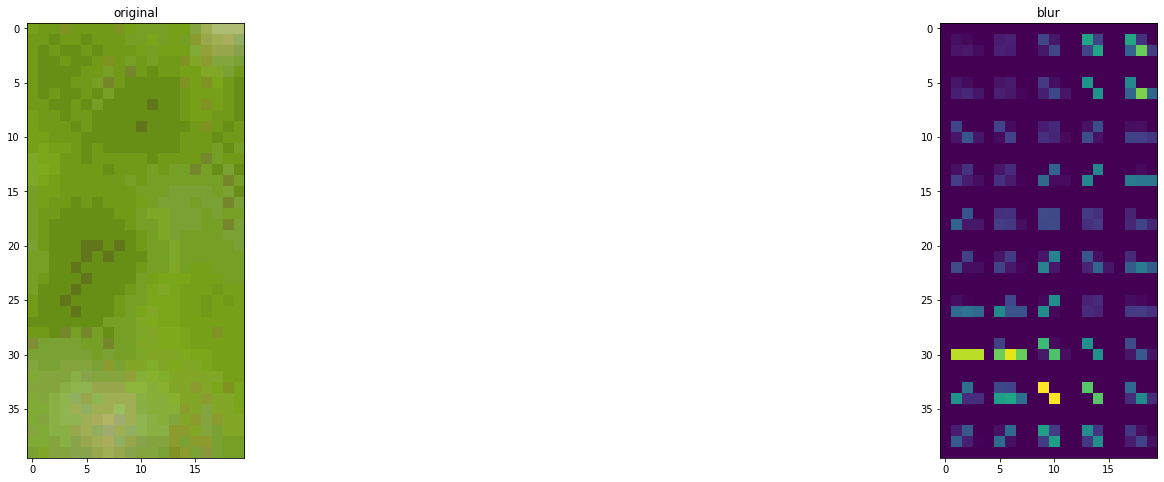

In [144]:
fig = plt.figure(figsize=(30,8))
ax = plt.subplot(1,2,1)
ax = plt.imshow(subImg)
ax = plt.title('original')

ax = plt.subplot(1,2,2)
ax = plt.imshow(hog_image)
ax = plt.title('blur')

**9.2 Image Segmentation Using K-mean clustering**

**9.2.1 K-Mean Clustering**

In [145]:
# Clean feature if NA
hogfeatures = np.array(hogfeatures)

# print(hogfeatures)

# K-mean Clustering
N=2
kmeans = KMeans(n_clusters=N,random_state=0)
clusters = kmeans.fit_predict(hogfeatures)

print(len(clusters))

13426


**9.2.2 Region Of Interest (ROI)**

In [146]:
# Reshape clusterID result to Grid
cluster_array = clusters.reshape(len(posRow),len(posCol))
cluster_array.shape

# View cluster_array Result
# print(cluster_array)
# cv2.imshow(cluster_array)

(98, 137)

In [147]:
print(cluster_array)

[[1 1 1 ... 1 0 0]
 [1 1 1 ... 1 0 0]
 [1 1 1 ... 1 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]]


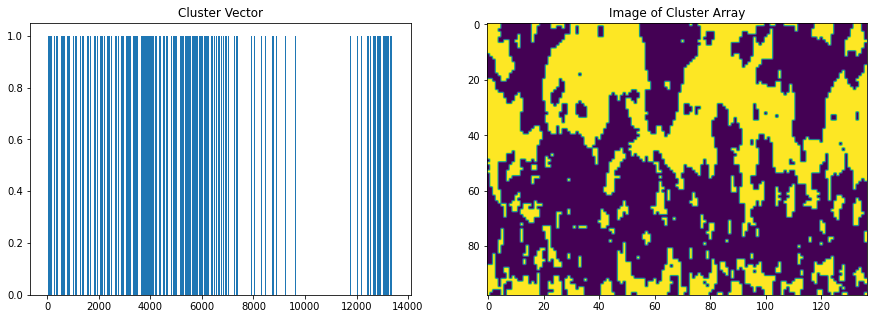

In [148]:
result = []

for i in range(len(clusters)):
    if clusters[i]:
        result.append(i)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].hist(result,bins=max(result)-min(result)+1)
ax[0].set_title("Cluster Vector")
ax[1].imshow(cluster_array)
ax[1].set_title("Image of Cluster Array")

plt.show()

**9.3 ROI: Region of Interest Drawing ROI bounding box**

**9.3.1 K-MEAN Clustering**

In [149]:
# ReAssign Label in case of multiple ROIs with the same clusterID
all_labels = label(cluster_array)

# Define bounding box parameter
Color = (255,0,0)
Thickness = 1

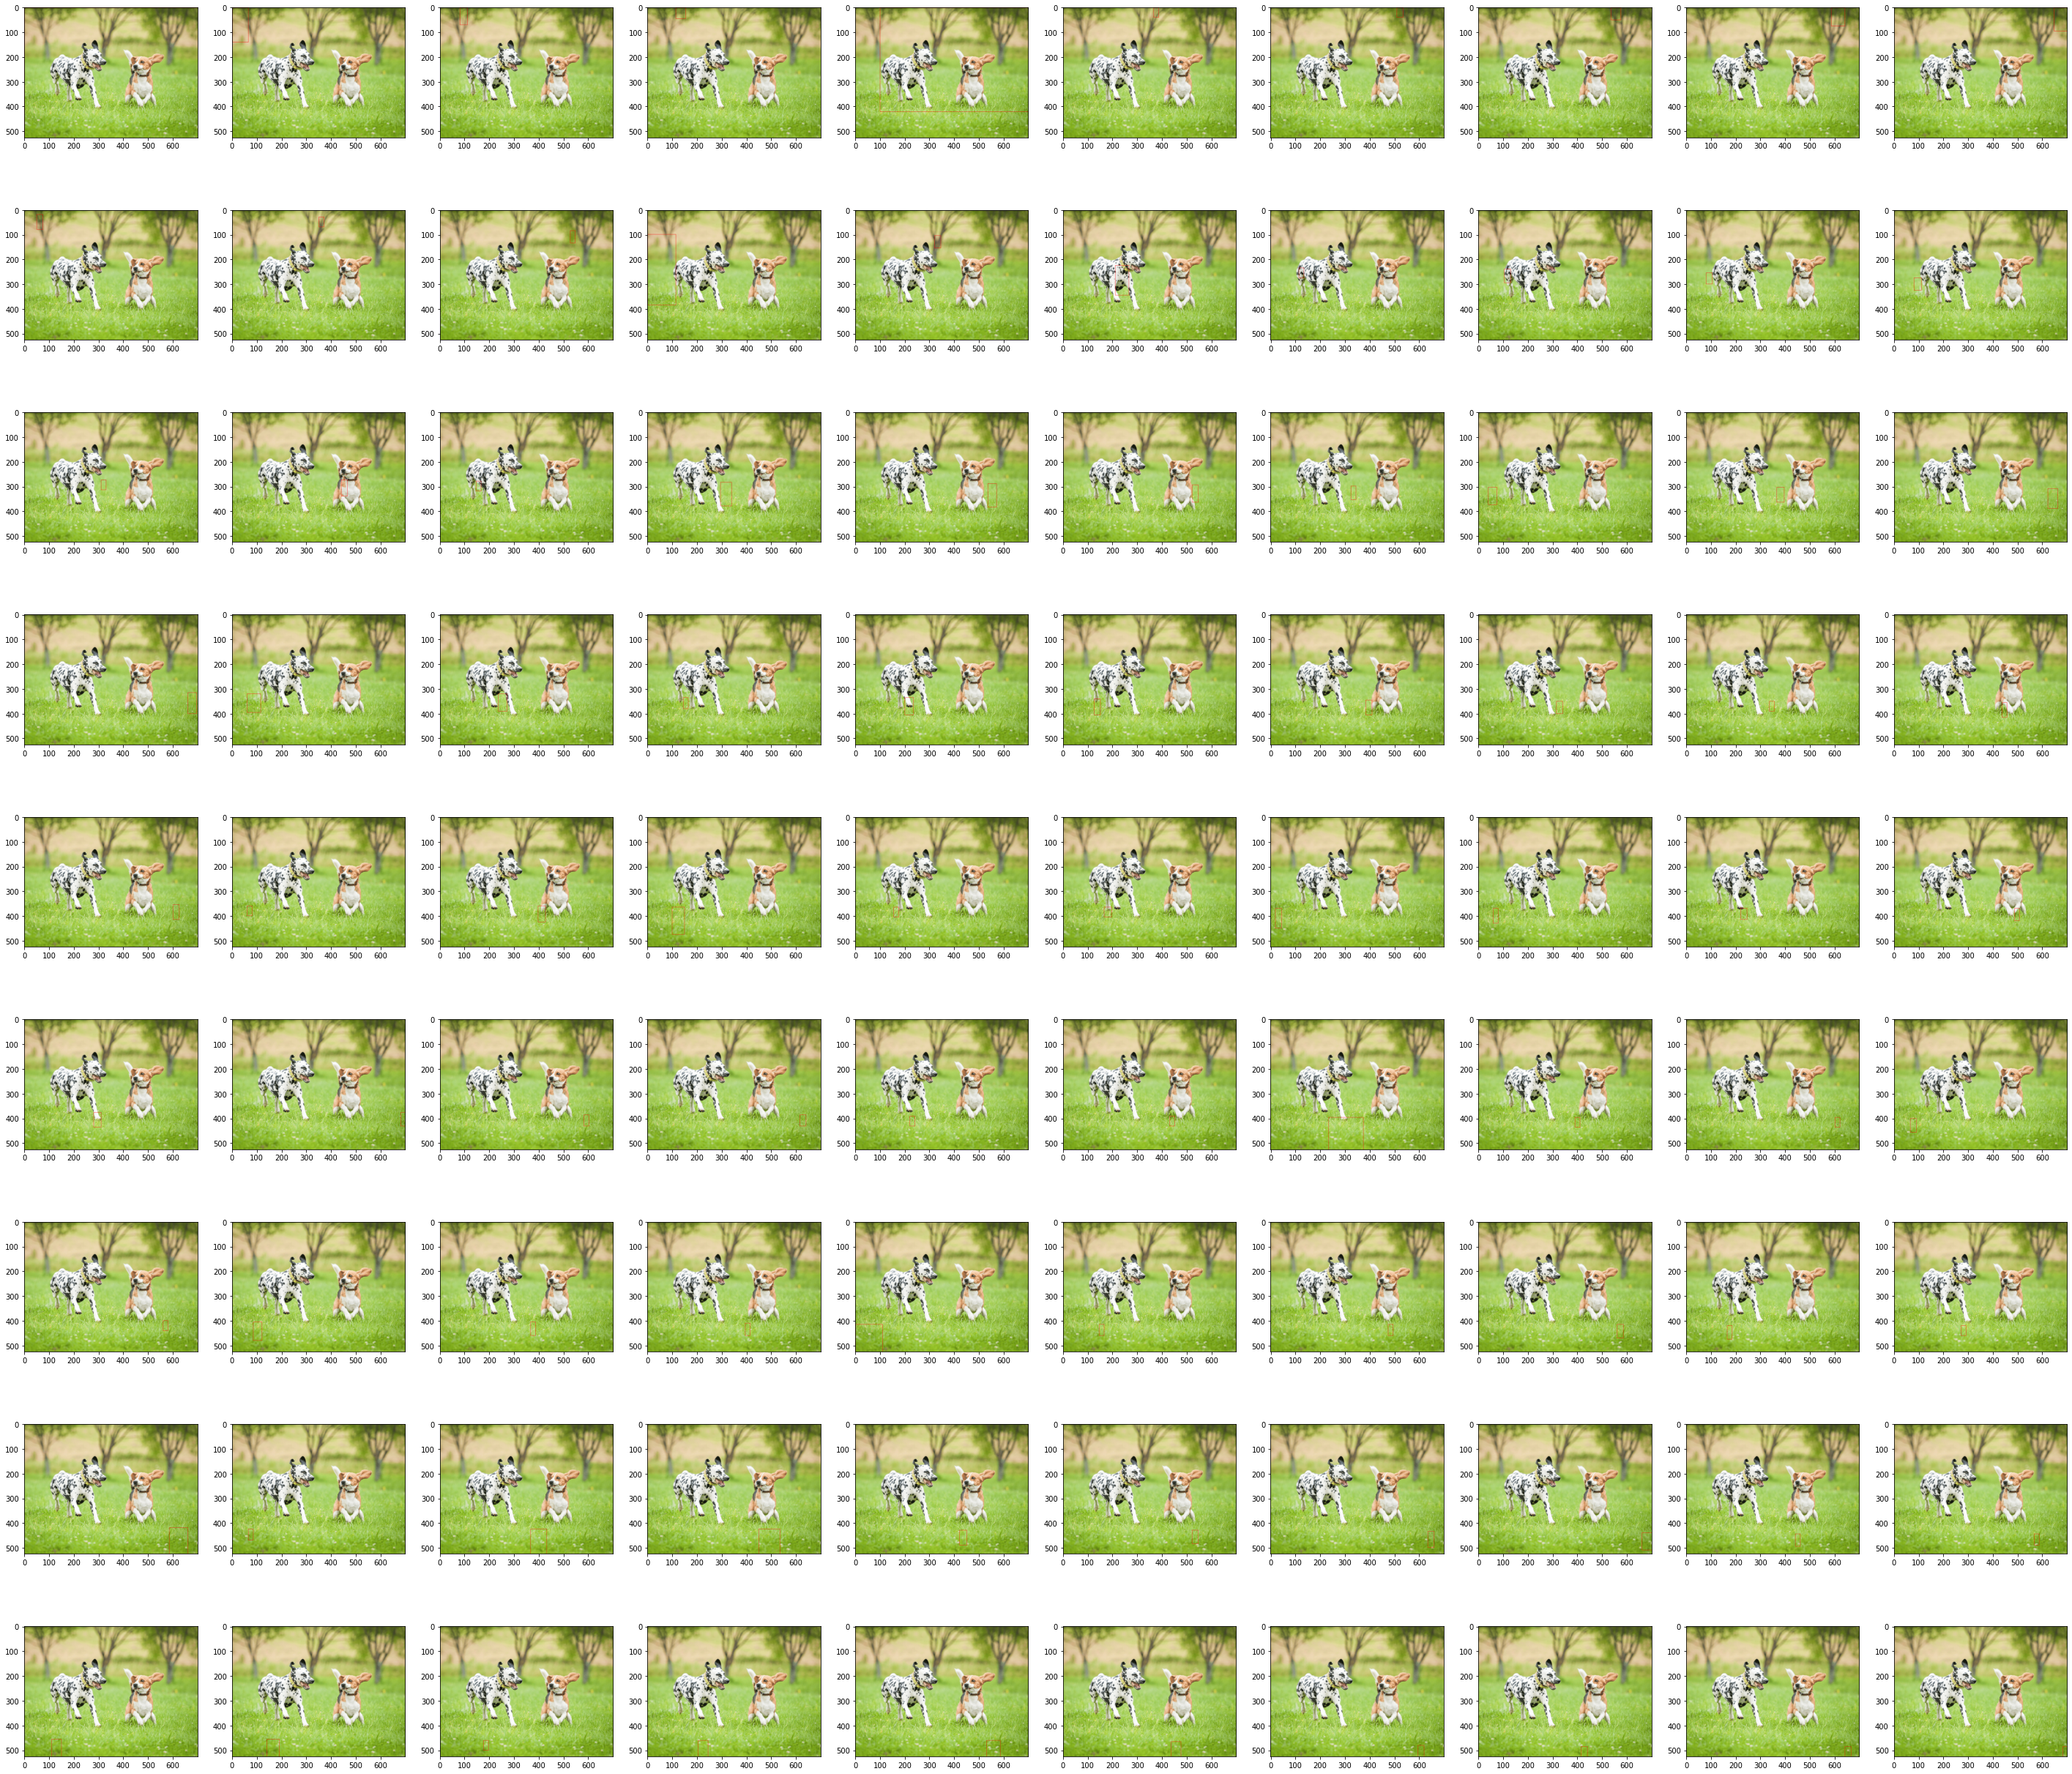

In [150]:
# ROI bounding box
nClass = np.unique(all_labels)

square = 10
ix = 1
plt.figure(figsize=(50,50))

for i in nClass:
    displayImg = np.array(selected_img)
    # calculate from grig to actual position
    objPos = np.argwhere(all_labels == i)
    startBlockH = objPos[:,0].min()
    endBlockH = objPos[:,0].max()
    startBlockW = objPos[:,1].min()
    endBlockW = objPos[:,1].max()
    startF = (posCol[startBlockW],posRow[startBlockH])
    endF = (posCol[endBlockW] + Block_size[1], posRow[endBlockH] + Block_size[0])

    # draw regtangle boundary
    ROI_bounding_img = cv2.rectangle(displayImg,startF,endF,Color,Thickness)

    ax = plt.subplot(square,square,ix)
    plt.imshow(ROI_bounding_img)
    ix += 1